# ViT implementation for PIBA dataset 

## Modelli

### 1. ViT Base

```bibtex
@article{dosovitskiy2021image,
  title={An image is worth 16x16 words: Transformers for image recognition at scale},
  author={Dosovitskiy, Alexey and Beyer, Lucas and Kolesnikov, Alexander and Weissenborn, Dirk and Zhai, Xiaohua and Unterthiner, Thomas and Dehghani, Mostafa and Minderer, Matthias and Heigold, Georg and Gelly, Sylvain and Uszkoreit, Jakob and Houlsby, Neil},
  journal={arXiv preprint arXiv:2010.11929},
  year={2021}
}

repository : https://github.com/google-research/vision_transformer

```bibtex
@misc{wu2020visual,
      title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, 
      author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda},
      year={2020},
      eprint={2006.03677},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}


```bibtex
@inproceedings{deng2009imagenet,
  title={Imagenet: A large-scale hierarchical image database},
  author={Deng, Jia and Dong, Wei and Socher, Richard and Li, Li-Jia and Li, Kai and Fei-Fei, Li},
  booktitle={2009 IEEE conference on computer vision and pattern recognition},
  pages={248--255},
  year={2009},
  organization={Ieee}
}



Vit base : https://huggingface.co/google/vit-base-patch16-224

architettura modello

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTConfig
# Numero di classi
num_classes = 6

# Inizializzazione del modello con ignore_mismatched_sizes=True se no errore di dimensioni
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes, ignore_mismatched_sizes=True)
#optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Sposto modello su MPS in locale no gpu
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### 2. DINO v2 

#### Citazione BibTeX

```bibtex
@article{oquab2023dinov2,
  title={DINOv2: Learning Robust Visual Features without Supervision},
  author={Oquab, Maxime and Darcet, Timothée and Moutakanni, Théo and Vo, Huy V. and Szafraniec, Marc and Khalidov, Vasil and Fernandez, Pierre and Haziza, Daniel and Massa, Francisco and El-Nouby, Alaaeldin and Assran, Mahmoud and Ballas, Nicolas and Galuba, Wojciech and Howes, Russell and Huang, Po-Yao and Li, Shang-Wen and Misra, Ishan and Rabbat, Michael and Sharma, Vasu and Synnaeve, Gabriel and Xu, Hu and Jegou, Hervé and Mairal, Julien and Labatut, Patrick and Joulin, Armand and Bojanowski, Piotr},
  journal={arXiv preprint arXiv:2304.07193},
  year={2023}
}

### 3.  MEDMAMBA MODEL 

```bibtex
@article{yue2024medmamba,
  title={MedMamba: Vision Mamba for Medical Image Classification},
  author={Yue, Yubiao e Li, Zhenzhang},
  journal={arXiv preprint arXiv:2403.03849},
  year={2024}
}

[repository GitHub] https://github.com/YubiaoYue/MedMamba/tree/main

## Attention maps & Gradcam

### Attention maps 

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from transformers import ViTForImageClassification, ViTConfig

# Constants
image_path = '/Users/luca.distefano/Desktop/Thesi/XAI-project/data/test/Adenoma/7abd6bdf-53ef-4919-a6ab-095ca0c1b284.png'
model_path = '/Users/luca.distefano/Desktop/Thesi/XAI-project/best_vit_model.pth'


def load_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(image).unsqueeze(0)  # aggiungo dimensione di batchh
    input_tensor = input_tensor.to(torch.float32)  
    
    return input_tensor, np.array(image.resize((224, 224)))

input_tensor, original_image = load_image(image_path)

# Check
if input_tensor is None:
    raise ValueError("The image was not loaded correctly.")

# abilito il gradiente
input_tensor.requires_grad_()

# Load the model with the configuration specific for the number of classes
config = ViTConfig.from_pretrained('google/vit-base-patch16-224', num_labels=6,output_attentions=True) 
# se non aggiungo output_attentions=True , TypeError: 'NoneType' object is not subscriptable
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', config=config, ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False) #strict false mi permette di caricare modello anche con mismatch di dim 
model.eval()

# funzione per ottenere le mappe di attenzione
def get_attention_maps(model, input_tensor):
    outputs = model.vit(input_tensor)
    attentions = outputs.attentions[-1].detach().cpu().numpy()
    return attentions

attentions = get_attention_maps(model, input_tensor)

# visualizzazione delle mappe di attenzione
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# immagine originale
axs[0].imshow(original_image)
axs[0].axis('off')
axs[0].set_title('Original Image')

# attention map
attention_map = attentions.mean(axis=1)[0]  # Average over heads
attention_map = attention_map.reshape(14, 14)  # Reshape to match the image size
attention_map = attention_map / attention_map.max()  # Normalize 

# Upscale to the size of the input image
attention_map = np.kron(attention_map, np.ones((16, 16)))  # 224 / 14 = 16

axs[1].imshow(original_image)
axs[1].imshow(attention_map, cmap='jet', alpha=0.6)  # Overlay the attention map
axs[1].axis('off')
axs[1].set_title('Attention Map')

# Save the plot
output_dir = '/Users/luca.distefano/Desktop/Thesi/XAI-project/output/vit'
output_filename = 'attention_map.png'

# Check 
counter = 1
while os.path.exists(os.path.join(output_dir, output_filename)):
    output_filename = f'attention_map{counter}.png'
    counter += 1

output_path = os.path.join(output_dir, output_filename)

# Save 
plt.savefig(output_path, format='png', bbox_inches='tight', pad_inches=0)

print('Operation completed')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'NoneType' object has no attribute 'detach'

### GRADCAM 

  	1.  Patch Embeddings:
        •   Layer: patch_embeddings.projection
        •   Questo è il primo layer convoluzionale che proietta l’immagine in uno spazio di embedding.
    2.  Encoder:
        •   Layer: layer (contiene 12 ViTLayer)
        •   Ogni ViTLayer ha componenti di attenzione e feed-forward, che si susseguono.
    3.  Classifier:
        •   Layer: classifier
        •   Questo è l’ultimo layer lineare che produce le previsioni finali.


    

gradcam applicato al layer di ebbedings , non ha molto senso 

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Operazione eseguita


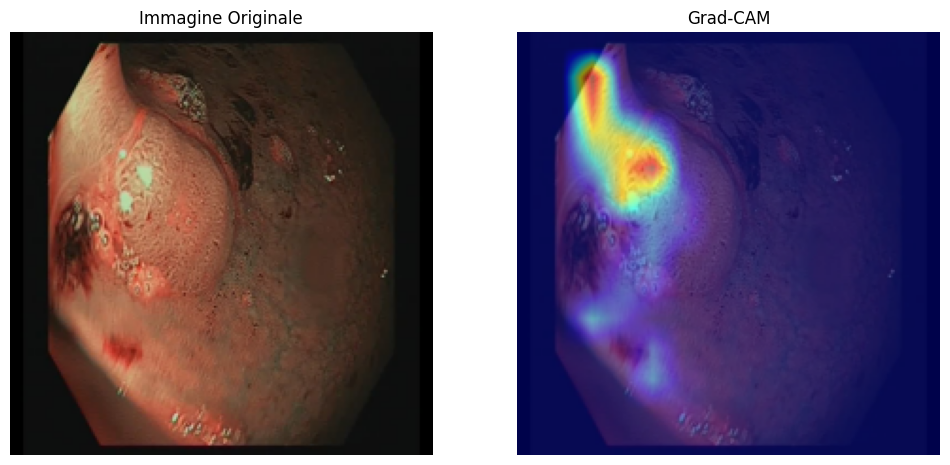

In [84]:
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from transformers import ViTForImageClassification, ViTConfig

# Costanti
image_path = '/Users/luca.distefano/Desktop/Thesi/XAI-project/data/test/Adenoma/7abd6bdf-53ef-4919-a6ab-095ca0c1b284.png'
model_path = '/Users/luca.distefano/Desktop/Thesi/XAI-project/best_vit_model.pth'

# Funzione di load e preprocessing dell'immagine
def load_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Errore nel caricamento dell'immagine: {e}")
        return None
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(image).unsqueeze(0)  # Aggiungo dimensione batch
    input_tensor = input_tensor.to(torch.float32)  
    
    return input_tensor, np.array(image.resize((224, 224)))

input_tensor, original_image = load_image(image_path)

# Check
if input_tensor is None:
    raise ValueError("L'immagine non è stata caricata correttamente.")

# Abilita i gradienti 
input_tensor.requires_grad_()

# Caricamento del modello con la configurazione specifica per il numero di classi
#Caricamento del modello:
#	•	Config: Crea una configurazione per il modello ViT con 6 classi
#	•	Caricamento del modello: Carico il modello pre-addestrato e i pesi salvati ignorando i pesi che non corrispondono
#	•	Impostazione in modalità di valutazione: Imposta il modello in modalità di valutazione per disabilitare il dropout e altre operazioni di training.

config = ViTConfig.from_pretrained('google/vit-base-patch16-224', num_labels=6)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', config=config, ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
model.eval()

# Wrapper per il modello:
#	•	Definizione del wrapper: Permette di accedere ai layer interni del modello, in particolare al layer patch_embeddings.projection(conv layer)
#	•	Inizializzazione: Usa il layer patch_embeddings.projection come target per la Grad-CAM.

class ViTWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ViTWrapper, self).__init__()
        self.model = model
        self.target_layer = model.vit.embeddings.patch_embeddings.projection
        

    def forward(self, x):
        return self.model(x).logits

model_wrapper = ViTWrapper(model)

# Inizializza Grad-CAM
cam = GradCAM(model=model_wrapper, target_layers=[model_wrapper.target_layer])

# Genera CAM
outputs = model(input_tensor)
logits = outputs.logits
target_category = torch.argmax(logits).item()
targets = [ClassifierOutputTarget(target_category)]

# GradCAM expects a tensor for the input
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Visualizza l'heatmap
grayscale_cam = grayscale_cam[0, :]
input_image = input_tensor.detach().squeeze().permute(1, 2, 0).cpu().numpy()  # Converti il tensore di input in immagine senza gradiente
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalizza l'immagine
visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

# Crea una figura con due subpplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Mostra l'immagine originale
axs[0].imshow(original_image)
axs[0].axis('off')
axs[0].set_title('Immagine Originale')

# Mostra l'immagine con l'attivazione
axs[1].imshow(visualization)
axs[1].axis('off')
axs[1].set_title('Grad-CAM')

# Salvataggio del plot 
output_dir = '/Users/luca.distefano/Desktop/Thesi/XAI-project/output/vit'
output_filename = 'heatmap.png'

#check
counter = 1
while os.path.exists(os.path.join(output_dir, output_filename)):
    output_filename = f'heatmap{counter}.png'
    counter += 1

output_path = os.path.join(output_dir, output_filename)

# Salva figura
plt.savefig(output_path, format='png', bbox_inches='tight', pad_inches=0)

print('Operazione eseguita')

 gradcam prova 2 - captum - cerco di applicare grad cam ai layer interni

In [102]:
import torch
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
import torch.nn.functional as F

# Definisci l'architettura del modello
class ViTModel(torch.nn.Module):
    def __init__(self, num_classes=6):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=False)
        self.vit.head = torch.nn.Linear(self.vit.head.in_features, num_classes)
    
    def forward(self, x):
        return self.vit(x)

# Crea un'istanza del modello
model = ViTModel()
model.eval()

# Carica i pesi del modello
state_dict = torch.load('/Users/luca.distefano/Desktop/Thesi/XAI-project/best_vit_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)


_IncompatibleKeys(missing_keys=['vit.cls_token', 'vit.pos_embed', 'vit.patch_embed.proj.weight', 'vit.patch_embed.proj.bias', 'vit.blocks.0.norm1.weight', 'vit.blocks.0.norm1.bias', 'vit.blocks.0.attn.qkv.weight', 'vit.blocks.0.attn.qkv.bias', 'vit.blocks.0.attn.proj.weight', 'vit.blocks.0.attn.proj.bias', 'vit.blocks.0.norm2.weight', 'vit.blocks.0.norm2.bias', 'vit.blocks.0.mlp.fc1.weight', 'vit.blocks.0.mlp.fc1.bias', 'vit.blocks.0.mlp.fc2.weight', 'vit.blocks.0.mlp.fc2.bias', 'vit.blocks.1.norm1.weight', 'vit.blocks.1.norm1.bias', 'vit.blocks.1.attn.qkv.weight', 'vit.blocks.1.attn.qkv.bias', 'vit.blocks.1.attn.proj.weight', 'vit.blocks.1.attn.proj.bias', 'vit.blocks.1.norm2.weight', 'vit.blocks.1.norm2.bias', 'vit.blocks.1.mlp.fc1.weight', 'vit.blocks.1.mlp.fc1.bias', 'vit.blocks.1.mlp.fc2.weight', 'vit.blocks.1.mlp.fc2.bias', 'vit.blocks.2.norm1.weight', 'vit.blocks.2.norm1.bias', 'vit.blocks.2.attn.qkv.weight', 'vit.blocks.2.attn.qkv.bias', 'vit.blocks.2.attn.proj.weight', 'vit.bl

In [103]:
# Trasformazione dell'immagine
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0)

image_path = '/Users/luca.distefano/Desktop/Thesi/XAI-project/data/test/Adenoma/3a48eed6-ceba-4b15-b824-04d0b4620103.png'
input_tensor = load_image(image_path)


In [104]:
# Predizione
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()
print(f'Predicted class: {predicted_class}')


Predicted class: 1


In [107]:
# Funzione per la Grad-CAM
def generate_gradcam(model, input_tensor, target_layer, target_class):
    gradcam = LayerGradCam(model.vit, target_layer)
    attributions = gradcam.attribute(input_tensor, target=target_class,relu_attributions=True)
    return attributions

# Specifica il layer di destinazione per Grad-CAM
target_layer = model.vit.blocks[-1].norm1

# Genera la heatmap Grad-CAM
attributions = generate_gradcam(model, input_tensor, target_layer, predicted_class)

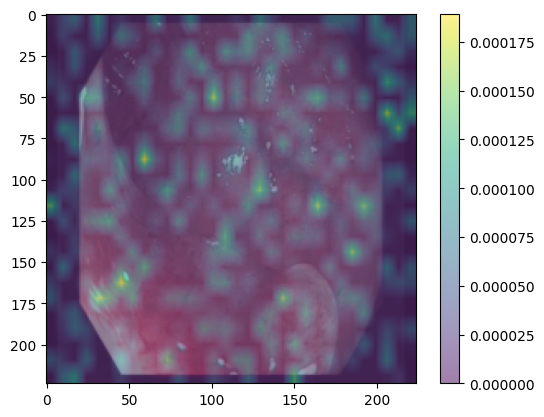

In [108]:
# Funzione alternativa per visualizzare la heatmap
def show_gradcam(attr, image, colormap='viridis'):
    attr = attr.squeeze().cpu().detach().numpy()
    # Assumiamo che l'output sia 768 (patch_size = 16, 224/16 = 14), quindi lo ridimensioniamo correttamente
    attr = attr.reshape(1, 1, 24, 32)  # Cambia a 14, 14 se patch_size = 16
    attr = F.interpolate(torch.tensor(attr), size=(224, 224), mode='bilinear', align_corners=False)
    attr = attr.squeeze().numpy()

    image = image.squeeze().cpu().detach().numpy().transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())

    plt.imshow(image, alpha=0.8)
    plt.imshow(attr, cmap=colormap, alpha=0.5)
    plt.colorbar()
    plt.show()

# Visualizza la heatmap Grad-CAM
show_gradcam(attributions, input_tensor)